**Import libraries **

In [0]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

**Download weather data**

In [2]:
!wget https://datacases.s3.us-east-2.amazonaws.com/datathon-2020/Ernst+and+Young/Dubai+Weather_20180101_20200316.txt

--2020-05-17 11:35:08--  https://datacases.s3.us-east-2.amazonaws.com/datathon-2020/Ernst+and+Young/Dubai+Weather_20180101_20200316.txt
Resolving datacases.s3.us-east-2.amazonaws.com (datacases.s3.us-east-2.amazonaws.com)... 52.219.105.74
Connecting to datacases.s3.us-east-2.amazonaws.com (datacases.s3.us-east-2.amazonaws.com)|52.219.105.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6915588 (6.6M) [text/plain]
Saving to: ‘Dubai+Weather_20180101_20200316.txt’

Dubai+Weather_20180 100%[===================>]   6.59M  4.30MB/s    in 1.5s    

2020-05-17 11:35:10 (4.30 MB/s) - ‘Dubai+Weather_20180101_20200316.txt’ saved [6915588/6915588]



**Weather Data**

From "Predicting weather disruption of public transport" case, weather parameters are described below:

city_name City name

lat Geographical coordinates of the location (latitude)

lon Geographical coordinates of the location (longitude)

main 

* main.temp Temperature

* main.feels_like This temperature parameter accounts for the human perception of weather

* main.pressure Atmospheric pressure (on the sea level), hPa

* main.humidity Humidity, %

* main.temp_min Minimum temperature at the moment. This is deviation from temperature that is possible for large cities and megalopolises geographically expanded (use these parameter optionally).

* main.temp_max Maximum temperature at the moment. This is deviation from temperature that is possible for large cities and megalopolises geographically expanded (use these parameter optionally).

wind

* wind.speed Wind speed. Unit Default: meter/sec

* wind.deg Wind direction, degrees (meteorological)

clouds

* clouds.all Cloudiness, %

rain

* rain.1h Rain volume for the last hour, mm

* rain.3h Rain volume for the last 3 hours, mm

weather (more info Weather condition codes)

* weather.id Weather condition id

* weather.main Group of weather parameters (Rain, Snow, Extreme etc.)

* weather.description Weather condition within the group

* weather.icon Weather icon id

dt Time of data calculation, unix, UTC

dt_isoDate and time in UTC format



In [3]:
df = pd.read_json("Dubai+Weather_20180101_20200316.txt")
df.dtypes

city_name     object
lat          float64
lon          float64
main          object
wind          object
clouds        object
weather       object
dt             int64
dt_iso        object
timezone       int64
rain          object
dtype: object

**Flat json data type**

In [4]:
s = df.apply(lambda x: pd.Series(x['weather']),axis=1).stack().reset_index(level=1, drop=True) # Weather column is a list which only contains one object
s.name = 'weather'
df = df.drop('weather', axis=1).join(s)
json_struct = json.loads(df.to_json(orient="records"))    
df_flat = pd.json_normalize(json_struct)
for col in df_flat.columns: # remove useless columns
  unique = df_flat[col].unique()
  print(f'{col} unique size: {unique.size}')

city_name unique size: 1
lat unique size: 1
lon unique size: 1
dt unique size: 19344
dt_iso unique size: 19344
timezone unique size: 1
rain unique size: 1
main.temp unique size: 3075
main.temp_min unique size: 2416
main.temp_max unique size: 2444
main.feels_like unique size: 3331
main.pressure unique size: 46
main.humidity unique size: 87
wind.speed unique size: 142
wind.deg unique size: 112
clouds.all unique size: 101
weather.id unique size: 17
weather.main unique size: 9
weather.description unique size: 17
weather.icon unique size: 16
rain.1h unique size: 23
rain.3h unique size: 18


Firstly, as observed from Dubai weather data, parameters including city name, latitude, longitude, time zone, and rain only contain one variable; hence, they can be dropped from the data table.

In [5]:
for col in df_flat.columns: # remove useless columns
  unique = df_flat[col].unique()
  if unique.size == 1:
    df_flat.drop(col, axis=1, inplace=True)
    print(f'drop {col}')
  else:
    print(f'{col} {unique.shape}: {unique[:5]}')

drop city_name
drop lat
drop lon
dt (19344,): [1514764800 1514768400 1514772000 1514775600 1514779200]
dt_iso (19344,): ['2018-01-01 00:00:00 +0000 UTC' '2018-01-01 01:00:00 +0000 UTC'
 '2018-01-01 02:00:00 +0000 UTC' '2018-01-01 03:00:00 +0000 UTC'
 '2018-01-01 04:00:00 +0000 UTC']
drop timezone
drop rain
main.temp (3075,): [14.99 14.63 14.03 13.78 14.28]
main.temp_min (2416,): [13.   12.   16.   19.31 20.61]
main.temp_max (2444,): [18. 17. 19. 21. 23.]
main.feels_like (3331,): [13.7  13.91 13.89 13.14 13.45]
main.pressure (46,): [1015 1016 1017 1014 1013]
main.humidity (87,): [87 93 68 64 56]
wind.speed (142,): [3.1 2.6 1.5 2.1 0.5]
wind.deg (112,): [150 180 160   0 340]
clouds.all (101,): [ 1  0 20 75 40]
weather.id (17,): [800 701 721 801 803]
weather.main (9,): ['Clear' 'Mist' 'Haze' 'Clouds' 'Rain']
weather.description (17,): ['sky is clear' 'mist' 'haze' 'few clouds' 'broken clouds']
weather.icon (16,): ['01n' '50n' '50d' '01d' '02n']
rain.1h (23,): [ nan 0.14 2.03 0.11 0.35]
ra

Secondly, in the weather parameter, each id matches one description and each it is more descriptive than main and icon. Therefore, id can represent the weather parameters and others can be dropped.

In [0]:
df_flat.drop(['weather.main', 'weather.icon', 'weather.description'], axis=1, inplace=True)

Thirdly, noticed from rain for 1 hour and rain for 3 hours, most of data are null value since there is less frequent to rain in Dubai, they can be replaced as 0 instead.

In [7]:
df=df_flat
print(df.isnull().sum())
df.fillna(0, inplace=True)

dt                     0
dt_iso                 0
main.temp              0
main.temp_min          0
main.temp_max          0
main.feels_like        0
main.pressure          0
main.humidity          0
wind.speed             0
wind.deg               0
clouds.all             0
weather.id             0
rain.1h            19319
rain.3h            19262
dtype: int64


In [8]:
df.describe()

,dt,main.temp,main.temp_min,main.temp_max,main.feels_like,main.pressure,main.humidity,wind.speed,wind.deg,clouds.all,weather.id,rain.1h,rain.3h
count,1.934700e+04,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000,19347.000000
mean,1.549584e+09,28.103518,26.662334,29.811445,27.685407,1009.415465,52.495891,3.879835,188.369153,13.758050,791.030806,0.000601,0.003641
std,2.010261e+07,7.329281,7.579672,7.241003,8.309739,8.016809,21.659532,2.099726,106.259695,26.485413,41.399420,0.023247,0.068180
min,1.514765e+09,10.890000,7.000000,12.000000,6.340000,972.000000,4.000000,0.300000,0.000000,0.000000,200.000000,0.000000,0.000000
25%,1.532176e+09,22.030000,20.925000,23.845000,20.750000,1003.000000,35.000000,2.340000,100.000000,0.000000,800.000000,0.000000,0.000000
50%,1.549588e+09,28.060000,26.670000,30.000000,27.320000,1011.000000,53.000000,3.600000,180.000000,1.000000,800.000000,0.000000,0.000000
75%,1.566992e+09,33.880000,32.810000,35.130000,34.890000,1016.000000,69.000000,5.100000,290.000000,19.000000,800.000000,0.000000,0.000000
max,1.584400e+09,45.940000,45.360000,48.000000,47.890000,1026.000000,100.000000,14.900000,360.000000,100.000000,804.000000,2.030000,3.810000


**Convert time format to datetime**

In [9]:
print(df.dt_iso, df.dtypes)
df.dt_iso = pd.to_datetime(df.dt_iso, format='%Y-%m-%d %H:%M:%S +0000 UTC')
print(df.dt_iso, df.dtypes)

0        2018-01-01 00:00:00 +0000 UTC
1        2018-01-01 01:00:00 +0000 UTC
2        2018-01-01 02:00:00 +0000 UTC
3        2018-01-01 03:00:00 +0000 UTC
4        2018-01-01 04:00:00 +0000 UTC
                     ...              
19342    2020-03-16 19:00:00 +0000 UTC
19343    2020-03-16 20:00:00 +0000 UTC
19344    2020-03-16 21:00:00 +0000 UTC
19345    2020-03-16 22:00:00 +0000 UTC
19346    2020-03-16 23:00:00 +0000 UTC
Name: dt_iso, Length: 19347, dtype: object dt                   int64
dt_iso              object
main.temp          float64
main.temp_min      float64
main.temp_max      float64
main.feels_like    float64
main.pressure        int64
main.humidity        int64
wind.speed         float64
wind.deg             int64
clouds.all           int64
weather.id           int64
rain.1h            float64
rain.3h            float64
dtype: object
0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00

As observed below, temperature and pressure are negatively correlated with each other. Meanwhile, min, max, feels like and average temperature are positively correlated with each other. Therefore, only the temperature should be kept and others can be dropped.

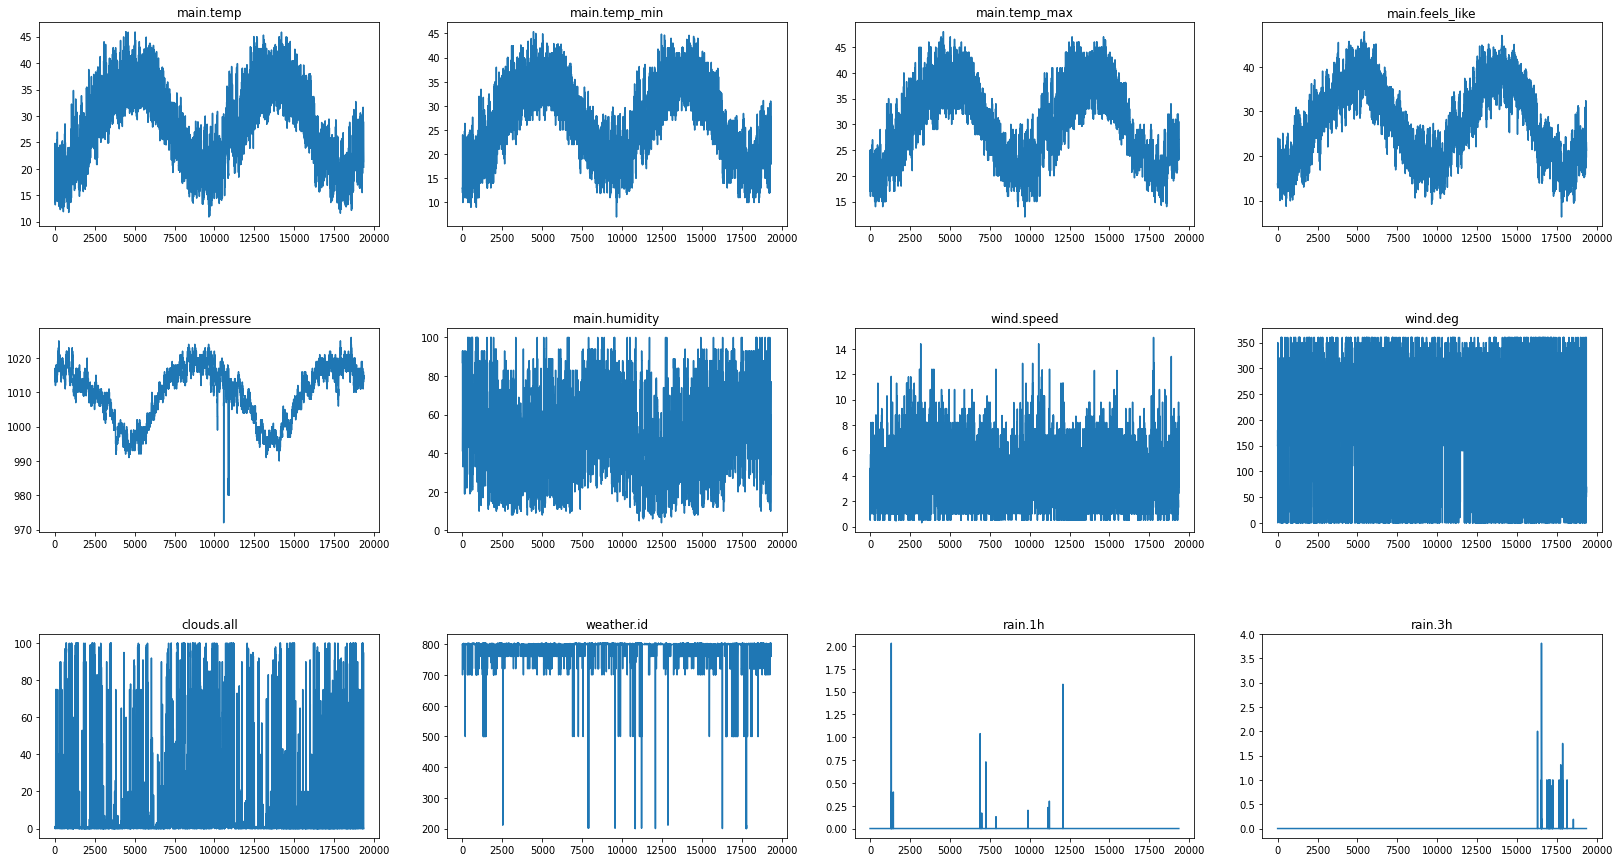

In [10]:
df.sort_values(by=['dt'], inplace=True)
dfwithouttime = df.drop(['dt','dt_iso'], axis=1)
#dfwithouttime=(dfwithouttime-dfwithouttime.min())/(dfwithouttime.max()-dfwithouttime.min()) #normalize
fig, axs = plt.subplots(3, 4, figsize=(28, 15))
fig.subplots_adjust(hspace=.5)
i = 0
j = 0
for col in dfwithouttime.columns:
    dfwithouttime[col].plot(ax=axs[i][j], title=col)
    j += 1
    if j == 4:
      j = 0
      i += 1

In [0]:
df.drop(['main.temp_min', 'main.temp_max', 'main.feels_like', 'main.pressure'], axis=1, inplace=True)

**Traffic data**

acci_time	Accident time

acci_name	categorization of the accident

acci_x	Latitude

acci_y	Longitude






**Download data from Dubai Pulse**

In [12]:
!wget http://data.bayanat.ae/ar/dataset/ad38cee7-f70e-4764-9c9d-aab760ce1026/resource/025ea6b2-a806-49c2-8294-4f3a97c09090/download/traffic_incidents-1.csv
!wget https://www.dubaipulse.gov.ae/dataset/c9263194-5ee3-4340-b7c0-3269b26acb43/resource/c3ece154-3071-4116-8650-e769d8416d88/download/traffic_incidents.csv

--2020-05-17 11:35:28--  http://data.bayanat.ae/ar/dataset/ad38cee7-f70e-4764-9c9d-aab760ce1026/resource/025ea6b2-a806-49c2-8294-4f3a97c09090/download/traffic_incidents-1.csv
Resolving data.bayanat.ae (data.bayanat.ae)... 185.141.13.100
Connecting to data.bayanat.ae (data.bayanat.ae)|185.141.13.100|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://data.bayanat.ae/ar/dataset/ad38cee7-f70e-4764-9c9d-aab760ce1026/resource/025ea6b2-a806-49c2-8294-4f3a97c09090/download/traffic_incidents-1.csv [following]
--2020-05-17 11:35:30--  https://data.bayanat.ae/ar/dataset/ad38cee7-f70e-4764-9c9d-aab760ce1026/resource/025ea6b2-a806-49c2-8294-4f3a97c09090/download/traffic_incidents-1.csv
Connecting to data.bayanat.ae (data.bayanat.ae)|185.141.13.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2716239 (2.6M) [text/csv]
Saving to: ‘traffic_incidents-1.csv’

traffic_incidents-1 100%[===================>]   2.59M   166KB

In [13]:
df1 = pd.read_csv("traffic_incidents.csv")
df2 = pd.read_csv("traffic_incidents-1.csv")
print(df1.dtypes, df2.dtypes)
print(df1.shape[0] + df2.shape[0])
df_union= pd.concat([df1, df2]).drop_duplicates()
print(df_union.shape)

acci_id        int64
acci_time     object
acci_name     object
acci_x       float64
acci_y       float64
dtype: object acci_id        int64
acci_time     object
acci_name     object
acci_x       float64
acci_y       float64
dtype: object
79599
(65667, 5)


First of all, only the accident time parameter can be used with weather data, other columns can be drop.

In [14]:
df_union = df_union[['acci_time']]
print(df_union.shape, df_union.acci_time.unique().shape)
df_union.tail

(65667, 1) (64600,)


<bound method NDFrame.tail of                  acci_time
0      17/05/2020 13:12:42
1      17/05/2020 13:24:43
2      17/05/2020 13:26:02
3      17/05/2020 13:37:07
4      17/05/2020 13:44:31
...                    ...
23816  27/06/2019 11:21:09
23817  27/06/2019 11:21:35
23818  27/06/2019 11:24:07
23819  27/06/2019 11:24:27
23820  27/06/2019 11:25:26

[65667 rows x 1 columns]>

In [0]:
df_union.acci_time = pd.to_datetime(df_union.acci_time, format='%d/%m/%Y %H:%M:%S')
df_union.sort_values(by=['acci_time'], inplace=True)

Additionally, the count of the number of traffic accidents occurred within each one hour can be added as one column.

,acci_time,count
0,2019-06-27 10:00:00,4
1,2019-06-27 11:00:00,19
2,2019-06-27 12:00:00,21
3,2019-06-27 13:00:00,26
4,2019-06-27 14:00:00,0
...,...,...
7800,2020-05-17 10:00:00,0
7801,2020-05-17 11:00:00,0
7802,2020-05-17 12:00:00,1
7803,2020-05-17 13:00:00,11


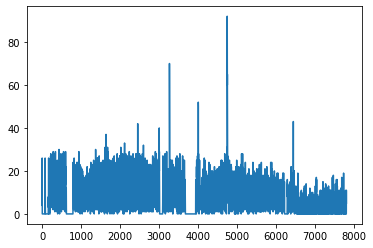

In [16]:
dfh = df_union.groupby([pd.Grouper(key='acci_time',freq='H')]).size().reset_index(name='count')
dfh['count'].plot()
dfh

After inner joining weather data and traffic accidents' data, only time range between 2019-06-27 10:00 and 2020-03-16 23:00 with a total of  6327 hours data can be used for analysis.

In [17]:
result = pd.merge(df, dfh, how='inner', left_on=['dt_iso'], right_on=['acci_time'])
result.drop(['acci_time', 'dt'], axis=1, inplace=True)
result.shape

(6327, 10)

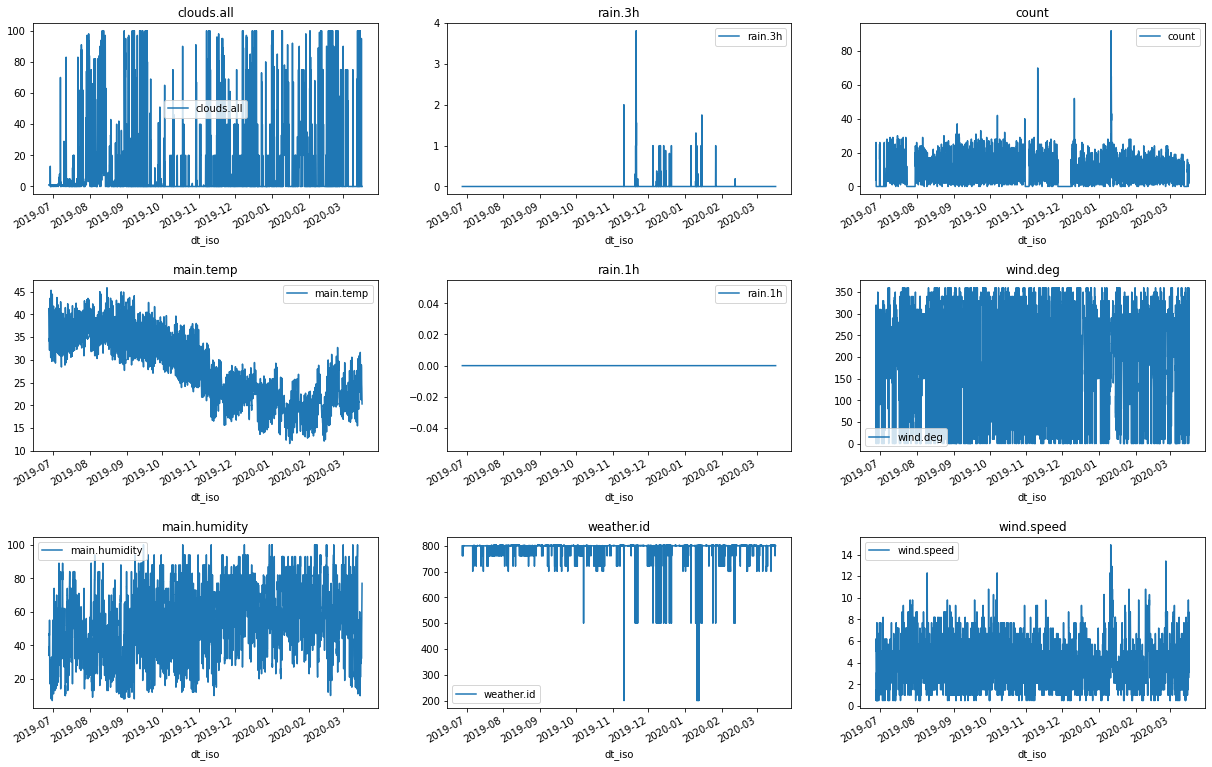

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(21, 14))
fig.subplots_adjust(hspace=.5)
i = 0
j = 0
for col in set(result.columns) - set(['dt_iso']):
    result.plot(x='dt_iso',y=col,ax=axs[i][j], title=col)
    j += 1
    if j == 3:
      j = 0
      i += 1

As seen from above, all rain for 1-hour data is 0, so rain 1h can be dropped.

In [0]:
result.drop('rain.1h', axis=1, inplace=True)

Interestingly, there are some rain 3-hours cases. After research, there was a flood during that time. Since there is barely raining in Dubai; as a result,  drainage measures might not be advanced in Dubai, and there was a significantly increasing number of traffic cases during that time duration.

Important features to predict accident counts per hour

main.temp        0.297278
wind.deg         0.255076
main.humidity    0.184519
wind.speed       0.141623
clouds.all       0.074437
dtype: float64
[11:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
wind.deg         0.430483
wind.speed       0.118081
main.humidity    0.111731
main.temp        0.109670
clouds.all       0.101215
dtype: float32


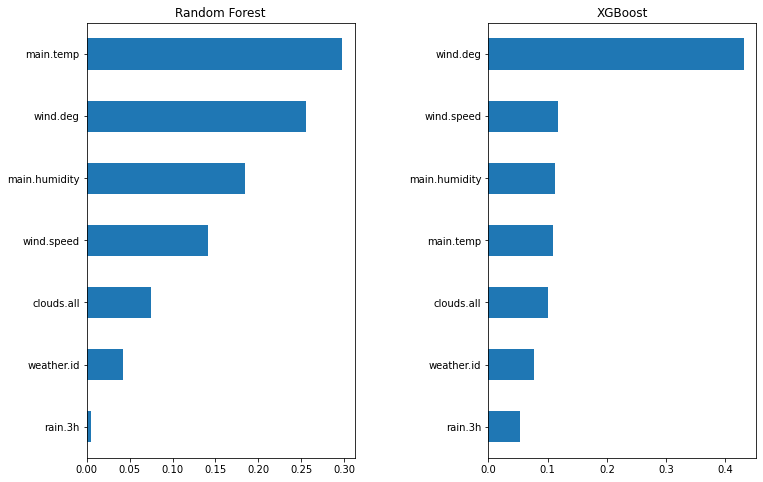

In [20]:
X = result.drop(['count', 'dt_iso'],axis=1)
y = result['count']

X = (X-X.min())/(X.max()-X.min()) # normalize the data
y = (y-y.min())/(y.max()-y.min()) # normalize the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_feature = pd.Series(random_forest.feature_importances_,index=X.columns)
rf_feature = rf_feature.sort_values()
print(rf_feature[::-1][:5])
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
fig.subplots_adjust(wspace=.5)
rf_feature.plot(kind="barh", ax=axs[0], title='Random Forest')
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)
xgb_feature = pd.Series(xgb.feature_importances_,index=X.columns)
xgb_feature = xgb_feature.sort_values()
xgb_feature.plot(kind="barh", ax=axs[1], title="XGBoost")
print(xgb_feature[::-1][:5])

After using both Random forest and XGBoost which are the most popular machine learning algorithms to evaluate the weather and traffic accidents, the windy condition and temperature are important features concluded by both algorithms. 

The assumption would be rain is more observable than wind, so people may not go out during the heavy rainy day, and the number of cars decreases. However, people may not be aware of the strong wind, and as a result, the wind has a stronger impact on traffic accidents.

Another assumption would be the temperature also plays an important role in traffic accidents. Perhaps, people should be aware of climate change with greenhouse. Protection of the environment is important to avoid exterme weather condition.


In [24]:
def test(model):
  pred = model.predict(X_test)

def cross_val(model):
  res = cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1)

  print(np.mean(res))

cross_val(xgb)
test(xgb)

cross_val(random_forest)
test(random_forest)

0.21253033333798896
0.21488870400506527


Both models average similar error rates after 10 times cross validation. 

**Conclusion**

The government should make people aware of climate change. Specifically, be aware of wind speed and build cars heavier and more stable.